In [2]:
from sklearn.cross_validation import train_test_split
from gensim.models.word2vec import Word2Vec
import numpy as np
import pandas as pd
import jieba
from sklearn.externals import joblib
from sklearn.svm import SVC
import sys  


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
d:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [57]:
#查看数据结构
neg=pd.read_excel('data/neg.xls',header=None,index=None)
neg.head()

,0
0,做为一本声名在外的流行书，说的还是广州的外企，按道理应该和我的生存环境差不多啊。但是一看之下...
1,作者有明显的自恋倾向，只有有老公养不上班的太太们才能像她那样生活。很多方法都不实用，还有抄袭...
2,作者完全是以一个过来的自认为是成功者的角度去写这个问题，感觉很不客观。虽然不是很喜欢，但是，...
3,作者提倡内调，不信任化妆品，这点赞同。但是所列举的方法太麻烦，配料也不好找。不是太实用。
4,作者的文笔一般，观点也是和市面上的同类书大同小异，不推荐读者购买。


### 载入数据，做预处理(分词)，切分训练集与测试集

In [4]:
cw = lambda x: list(jieba.cut(x))
neg[0].head().apply(cw)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\p186644\AppData\Local\Temp\jieba.cache
Loading model cost 1.076 seconds.
Prefix dict has been built succesfully.


0    [做, 为, 一本, 声名在外, 的, 流行, 书, ，, 说, 的, 还是, 广州, 的,...
1    [作者, 有, 明显, 的, 自恋, 倾向, ，, 只有, 有, 老公, 养, 不, 上班,...
2    [作者, 完全, 是, 以, 一个, 过来, 的, 自, 认为, 是, 成功者, 的, 角度...
3    [作者, 提倡, 内, 调, ，, 不, 信任, 化妆品, ，, 这点, 赞同, 。, 但是...
4    [作者, 的, 文笔, 一般, ，, 观点, 也, 是, 和, 市面上, 的, 同类, 书,...
Name: 0, dtype: object

In [5]:
def load_file_and_preprocessing():
    neg=pd.read_excel('data/neg.xls',header=None,index=None)
    pos=pd.read_excel('data/pos.xls',header=None,index=None)
    
    cw = lambda x: list(jieba.cut(x))
    pos['words'] = pos[0].apply(cw)
    neg['words'] = neg[0].apply(cw)
    #创建label数组
    y = np.concatenate((np.ones(len(pos)), np.zeros(len(neg))))
    #利用train_test_split分割训练集和测试集,测试集的大小为0.2
    x_train, x_test, y_train, y_test = train_test_split(np.concatenate((pos['words'], neg['words'])), y, test_size=0.2)
    #保存矩阵
    np.save('svm_data/y_train.npy',y_train)
    np.save('svm_data/y_test.npy',y_test)
    return x_train,x_test

### 对每个句子的所有词向量取均值，来生成一个句子的vector

In [6]:
#获得向量中所有词的向量平均值，imdb_w2v代表模型
def build_sentence_vector(text, size,imdb_w2v):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in text:
        try:
            #获得词向量，并转换维度
            vec += imdb_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    #返回一句话的所有词向量的和
    return vec

### 计算词向量

In [11]:
#计算词向量
def get_train_vecs(x_train,x_test):
    n_dim = 300
    #初始化模型和词表
    #Word2Vec建立空模型模型
    imdb_w2v = Word2Vec(size=n_dim, min_count=10)
    #将x_train导入模型
    imdb_w2v.build_vocab(x_train)
    
    #在评论训练集上进行模型训练
    imdb_w2v.train(x_train,total_examples=imdb_w2v.corpus_count,epochs=imdb_w2v.iter)
    #,total_examples=x_train.shape[0]
    #生成所有训练句子的词向量
    train_vecs = np.concatenate([build_sentence_vector(z, n_dim,imdb_w2v) for z in x_train])
    #将生成的训练向量保存
    np.save('svm_data/train_vecs.npy',train_vecs)
    print(train_vecs.shape)
    #在测试集上训练
    imdb_w2v.train(x_test,total_examples=1,epochs=1)
    #,total_examples=x_test.shape[0]
    #保存模型
    imdb_w2v.save('svm_data/w2v_model/w2v_model.pkl')
    #将测试集中的数据生成测试向量
    test_vecs = np.concatenate([build_sentence_vector(z, n_dim,imdb_w2v) for z in x_test])
    np.save('svm_data/test_vecs.npy',test_vecs)
    print(test_vecs.shape)

In [8]:
x_train,x_test = load_file_and_preprocessing()


In [9]:
x_train.shape[0]

16884

In [12]:
get_train_vecs(x_train,x_test)

(16884, 300)
(4221, 300)


In [13]:
def get_data():
    #加载之前保存的向量数据
    #训练向量
    train_vecs=np.load('svm_data/train_vecs.npy')
    #训练label
    y_train=np.load('svm_data/y_train.npy')
    #测试向量
    test_vecs=np.load('svm_data/test_vecs.npy')
    #测试label
    y_test=np.load('svm_data/y_test.npy') 
    return train_vecs,y_train,test_vecs,y_test

### 训练svm模型

In [14]:
def svm_train(train_vecs,y_train,test_vecs,y_test):
    #使用SKLEARN的模型训练
    clf=SVC(kernel='rbf',verbose=True)
    clf.fit(train_vecs,y_train)
    joblib.dump(clf, 'svm_data/svm_model/model.pkl')
    #显示在测试集的准确率
    print(clf.score(test_vecs,y_test))

In [15]:
train_vecs,y_train,test_vecs,y_test = get_data()
svm_train(train_vecs,y_train,test_vecs,y_test)

[LibSVM]0.795782989813


In [ ]:
def forest_train(train_vecs,y_train,test_vecs,y_test):
    from sklearn.ensemble import RandomForestClassifier
    forest=RandomForestClassifier(n_estimators=100,max_depth=2,random_state=0)
    forest.fit(train_vecs,y_train)
    joblib.dump(forest, 'svm_data/svm_model/model_forest.pkl')
    #显示在测试集的准确率
    print('RandomForestClassifier acc',forest.score(test_vecs,y_test))
forest_train(train_vecs,y_train,test_vecs,y_test)

In [42]:
def grad_train(train_vecs,y_train,test_vecs,y_test):
    from sklearn.ensemble import GradientBoostingClassifier
    grad=GradientBoostingClassifier()
    grad.fit(train_vecs,y_train)
    joblib.dump(grad, 'svm_data/svm_model/model_forest.pkl')
    #显示在测试集的准确率
    print(' GradientBoostingClassifier acc',grad.score(test_vecs,y_test))
grad_train(train_vecs,y_train,test_vecs,y_test)


 GradientBoostingClassifier acc 0.820658611703


In [44]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold,learning_curve

In [47]:
kfold = StratifiedKFold(n_splits=10)
random_state = 2 #随机种子

In [48]:
train_x=train_vecs
train_y=y_train
#将分类器添加进队列中
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier
          (random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [50]:
#将结果添加到cv_results中
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier,train_x, y = train_y,scoring = "accuracy", cv = kfold, n_jobs=4))

In [51]:
cv_means=[]
cv_std=[]
#准确率的平均值和方差
for cv_result in cv_results:
    cv_means.append(np.mean(cv_result))
    cv_std.append(np.std(cv_result))
#显示整体结果
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                            "Algorithm":["SVC","DecisionTree","AdaBoost",
         "RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron",
         "KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

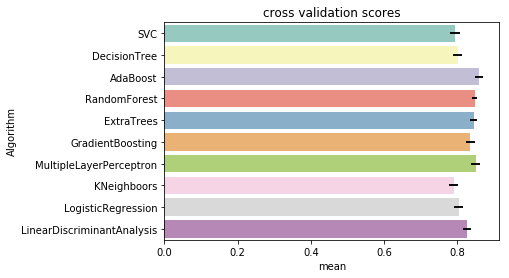

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
#打印各个算法的结果和方差
g=sns.barplot('CrossValMeans','Algorithm',data=cv_res,palette='Set3',orient = "h",**{'xerr':cv_std})
g.set_xlabel('mean')
g=g.set_title('cross validation scores')
plt.show()

In [56]:
def ada_train(train_vecs,y_train,test_vecs,y_test):
    from sklearn.ensemble import AdaBoostClassifier
    ada=AdaBoostClassifier()
    ada.fit(train_vecs,y_train)
    joblib.dump(ada, 'svm_data/svm_model/model_ada.pkl')
    #显示在测试集的准确率
    print(' GradientBoostingClassifier acc',ada.score(test_vecs,y_test))
ada_train(train_vecs,y_train,test_vecs,y_test)

 GradientBoostingClassifier acc 0.793887704335


In [16]:
#在输入数据进行训练时需要先将其转换为向量
def get_predict_vecs(words):
    n_dim = 300
    #加载模型
    imdb_w2v = Word2Vec.load('svm_data/w2v_model/w2v_model.pkl')
    #imdb_w2v.train(words)
    train_vecs = build_sentence_vector(words, n_dim,imdb_w2v)
    return train_vecs

### 对单个句子进行情感判断 

In [58]:
#使用sklearn进行预测
def svm_predict(string):
    words=jieba.lcut(string)
    words_vecs=get_predict_vecs(words)
    clf=joblib.load('svm_data/svm_model/model.pkl')
     
    result=clf.predict(words_vecs)
    
    if int(result[0])==1:
        print (string,' positive')
    else:
        print (string,' negative')

In [59]:
#使用sklearn进行预测
def forest_predict(string):
    words=jieba.lcut(string)
    words_vecs=get_predict_vecs(words)
    clf=joblib.load('svm_data/svm_model/model_forest.pkl')
     
    result=clf.predict(words_vecs)
    
    if int(result[0])==1:
        print (string,' positive')
    else:
        print (string,' negative')

In [62]:
#使用sklearn进行预测
def ada_predict(string):
    words=jieba.lcut(string)
    words_vecs=get_predict_vecs(words)
    clf=joblib.load('svm_data/svm_model/model_ada.pkl')
     
    result=clf.predict(words_vecs)
    
    if int(result[0])==1:
        print (string,' positive')
    else:
        print (string,' negative')

In [63]:
##对输入句子情感进行判断
strings=['质量还可以','用的很满意','缺点很多','用起来非常好，没有缺点']
for string in strings:
    print('svm_predict \n',svm_predict(string))
    print('ada_predict \n',ada_predict(string))
    print('forest_predict \n',forest_predict(string))

质量还可以  positive
svm_predict 
 None
质量还可以  positive
ada_predict 
 None
质量还可以  positive
forest_predict 
 None
用的很满意  positive
svm_predict 
 None
用的很满意  positive
ada_predict 
 None
用的很满意  positive
forest_predict 
 None
缺点很多  negative
svm_predict 
 None
缺点很多  negative
ada_predict 
 None
缺点很多  negative
forest_predict 
 None
用起来非常好，没有缺点  positive
svm_predict 
 None
用起来非常好，没有缺点  positive
ada_predict 
 None
用起来非常好，没有缺点  positive
forest_predict 
 None


In [89]:
#数字在排序数组中出现的次数
def get_first_k(arr,start,end,num):
	#二分查找，
	if start > end:
		return -1
	midIndex = (start+end)//2
	if arr[midIndex] > num:
		end = midIndex-1
		#get_first_k(arr,start,midIndex-1,num)
	elif arr[midIndex] < num:
		start = midIndex+1
		#get_first_k(arr,midIndex+1,end,num)
	else:
		if midIndex == 0:
			return 0
		elif arr[midIndex-1] == num:
			end = midIndex
			#get_first_k(arr,start,midIndex,num)
		else:
			return midIndex-1
	return get_first_k(arr,start,end,num)
#def get_last_k(arr,start,end,num):
arr = [1,4,5,6,6,6,6,8,9,11]
print(get_first_k(arr,0,len(arr)-1,num=8))

6
